In [209]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import TOFPET_cal_lib as TPcal
from scipy import interpolate
import time
import build_data_df_mine as bd

%matplotlib nbagg
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [210]:
coeffs_qdc_0 = pd.read_hdf('../CALIBRATION_FILES/asic0_efine_cal_spl.h5',key='efine')
coeffs_qdc_2 = pd.read_hdf('../CALIBRATION_FILES/asic2_efine_cal_spl.h5',key='efine')
coeffs_tdc   = pd.read_hdf('../CALIBRATION_FILES/asic0_tfine_cal.h5',key='tfine_cal')
#coeffs_tdc_2 = pd.read_hdf('/home/viherbos/DATA_daq/CAL_results/asic2_tfine_cal.h5',key='tfine_cal')

coeffs_qdc = coeffs_qdc_0.append(coeffs_qdc_2).reset_index()


#with pd.HDFStore('/home/viherbos/DATA_daq/CAL_results/asic0_tfine_cal.h5') as a:
#    print(a.keys())
data   = pd.read_hdf('/analysis/10871/hdf5/data/run_10871_0000_trigger1_waveforms.h5',key='data',start=0,stop=100000)

In [211]:
data2 = pd.read_hdf('/analysis/10893/hdf5/data/run_10893_0000_trigger1_waveforms.h5',key='data',start=0,stop=100000)

# INTEGRATION WINDOW COMPUTATION

In [212]:
bd.compute_integration_window_size(data)

In [213]:
bd.compute_integration_window_size(data2)

# TFINE & EFINE PREPROCESSING

In [214]:
data['tfine'] = (data['tfine'] - 1024 + 14) % 1024
data['efine'] = (data['efine'] - 1024 + 14) % 1024

In [215]:
data2['tfine'] = (data2['tfine'] - 1024 + 14) % 1024
data2['efine'] = (data2['efine'] - 1024 + 14) % 1024

# APPLY TDC CORRECTION

In [216]:
data = bd.apply_tdc_correction(data,coeffs_tdc)

In [217]:
data2 = bd.apply_tdc_correction(data2,coeffs_tdc)

# DATA SELECTION

In [218]:
window_l = 80
window_u = 130
#data_sample = data_e[(data_e['channel_id']==ch) & (data_e['tac_id']==tc) 
#                     & (data_e['integ_w'] >= window_l) & (data_e['integ_w'] < window_u) ]
data_sample = data[(data['intg_w'] >= window_l) & (data['intg_w'] < window_u) ]
#data_sample = data

In [219]:
data_sample2 = data2[(data2['intg_w'] >= window_l) & (data2['intg_w'] < window_u) ]

# APPLY QDC CORRECTION

In [220]:
start_time = time.time()

data_0 = bd.apply_qdc_spl_correction(data_sample[data_sample['tofpet_id']==0],coeffs_qdc)
data_2 = bd.apply_qdc_spl_correction(data_sample[data_sample['tofpet_id']==2],coeffs_qdc)
data_sample = data_0.append(data_2).reset_index()

#data_sample = bd.apply_qdc_p_correction(data_sample,coeffs_qdc)
print("It took %f seconds" % (time.time()-start_time))

It took 1.500598 seconds


In [221]:
start_time = time.time()

data_0_2 = bd.apply_qdc_spl_correction(data_sample2[data_sample2['tofpet_id']==0],coeffs_qdc)
data_2_2 = bd.apply_qdc_spl_correction(data_sample2[data_sample2['tofpet_id']==2],coeffs_qdc)
data_sample2 = data_0_2.append(data_2_2).reset_index()

#data_sample = bd.apply_qdc_p_correction(data_sample,coeffs_qdc)
print("It took %f seconds" % (time.time()-start_time))

It took 21.902798 seconds


<IPython.core.display.Javascript object>


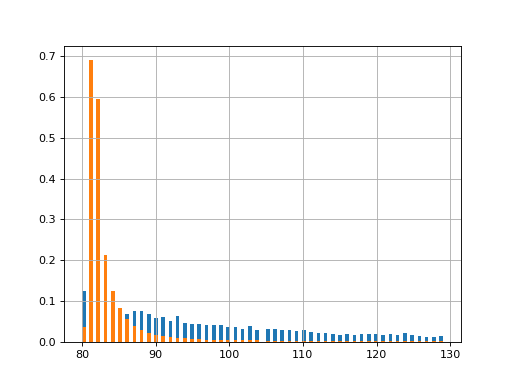

<AxesSubplot:>

In [222]:
plt.figure()
data_sample['intg_w'].hist(bins=100, density=1)
data_sample2['intg_w'].hist(bins=100, density=1)

# COMPUTE TCOARSE_EXTENDED

In [32]:
data_sample['tcoarse']      = data_sample.tcoarse.astype(np.int32)
data_sample['tcoarse_diff'] = data_sample.tcoarse.diff()
data_sample['nloops']       = bd.compute_tcoarse_nloops_per_event(data_sample)
data_sample['tcoarse_extended'] = bd.compute_extended_tcoarse(data_sample)
data_sample.drop(columns=['tcoarse_diff','nloops'], inplace=True)

In [33]:
data_sample2['tcoarse']      = data_sample2.tcoarse.astype(np.int32)
data_sample2['tcoarse_diff'] = data_sample2.tcoarse.diff()
data_sample2['nloops']       = bd.compute_tcoarse_nloops_per_event(data_sample2)
data_sample2['tcoarse_extended'] = bd.compute_extended_tcoarse(data_sample2)
data_sample2.drop(columns=['tcoarse_diff','nloops'], inplace=True)

# FIND CLUSTERS

In [34]:
bd.compute_evt_number_combined_with_cluster_id(data_sample)
nuniq = data_sample.groupby(['cluster'])['sensor_id'].nunique().rename('n_sipms')
clustered_df = data_sample.join(nuniq, on='cluster')

In [35]:
bd.compute_evt_number_combined_with_cluster_id(data_sample2)
nuniq = data_sample2.groupby(['cluster'])['sensor_id'].nunique().rename('n_sipms')
clustered_df2 = data_sample2.join(nuniq, on='cluster')

<IPython.core.display.Javascript object>


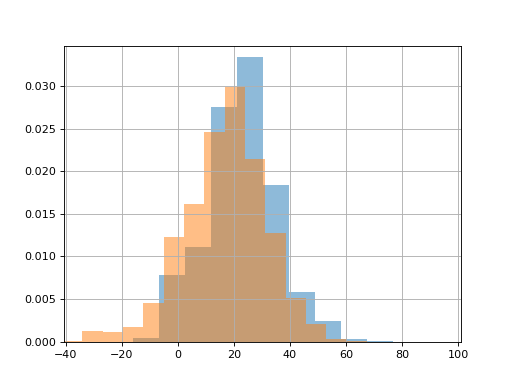

<AxesSubplot:>

In [36]:
plt.figure()
clustered_df[clustered_df['tofpet_id']==0]['efine_corrected'].hist(bins=100,density=1,alpha=0.5)
clustered_df2[clustered_df2['tofpet_id']==0]['efine_corrected'].hist(bins=100,density=1,alpha=0.5)

# Event processing

In [37]:
energy_array_h = []
energy_array_f = []
sipm_array   = []

for i in clustered_df['cluster'].unique():
    if i != -1:
        evt = clustered_df[clustered_df['cluster']==i]
        #print(evt['tofpet_id'].unique())
        
        #Rough coincidence filter
        if evt['tofpet_id'].unique().size == 2:
            hamamatsu = evt[evt['tofpet_id']==0]
            fbk       = evt[evt['tofpet_id']==2]
            energy_hamamatsu = np.sum(hamamatsu['efine_corrected'])
            energy_fbk       = np.sum(fbk['efine_corrected'])
            energy_array_h.append(energy_hamamatsu)
            energy_array_f.append(energy_fbk)
            #sipm_array.append(evt['n_sipms'].unique()[0])
energy_array_h = np.array(energy_array_h)
energy_array_f = np.array(energy_array_f)

In [38]:
energy_array_h2 = []
energy_array_f2 = []
sipm_array2   = []

for i in clustered_df2['cluster'].unique():
    if i != -1:
        evt = clustered_df2[clustered_df2['cluster']==i]
        #print(evt['tofpet_id'].unique())
        
        #Rough coincidence filter
        if evt['tofpet_id'].unique().size == 2:
            hamamatsu2 = evt[evt['tofpet_id']==0]
            fbk2       = evt[evt['tofpet_id']==2]
            energy_hamamatsu2 = np.sum(hamamatsu2['efine_corrected'])
            energy_fbk2       = np.sum(fbk2['efine_corrected'])
            energy_array_h2.append(energy_hamamatsu2)
            energy_array_f2.append(energy_fbk2)
            #sipm_array.append(evt['n_sipms'].unique()[0])
energy_array_h2 = np.array(energy_array_h2)
energy_array_f2 = np.array(energy_array_f2)

<IPython.core.display.Javascript object>


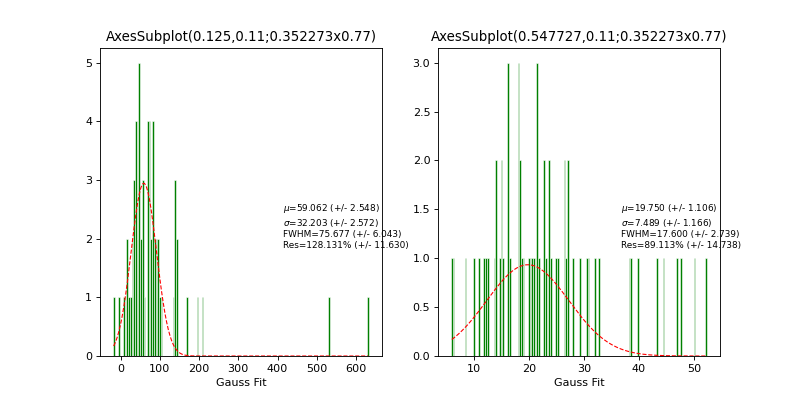

In [39]:
fig = plt.figure(figsize=[10,5])

#energy_array = energy_array[(energy_array>-100) & (energy_array<300)]


axis = fig.add_subplot(121)
coeff,coeff_err,chisq_r=TPcal.gauss_fit(energy_array_h,150,True,axis,'Gauss Fit','','',[0.65,0.5,"left"])

axis2 = fig.add_subplot(122)
coeff,coeff_err,chisq_r=TPcal.gauss_fit(energy_array_f,150,True,axis2,'Gauss Fit','','',[0.65,0.5,"left"])



<IPython.core.display.Javascript object>


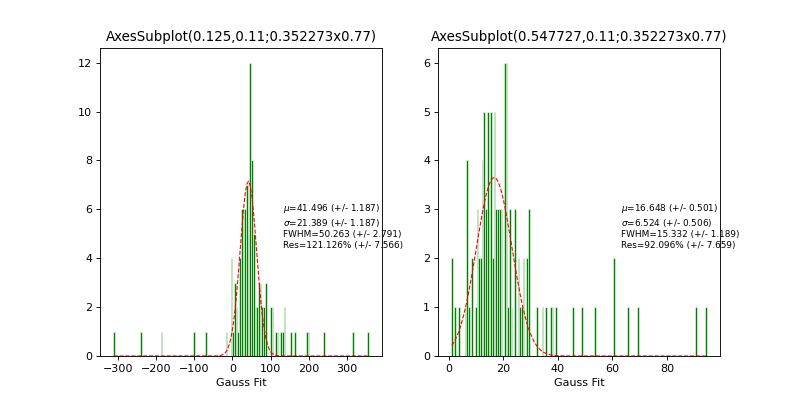

In [40]:
fig = plt.figure(figsize=[10,5])

#energy_array = energy_array[(energy_array>-100) & (energy_array<300)]


axis = fig.add_subplot(121)
coeff,coeff_err,chisq_r=TPcal.gauss_fit(energy_array_h2,150,True,axis,'Gauss Fit','','',[0.65,0.5,"left"])

axis2 = fig.add_subplot(122)
coeff,coeff_err,chisq_r=TPcal.gauss_fit(energy_array_f2,150,True,axis2,'Gauss Fit','','',[0.65,0.5,"left"])


In [ ]:
clustered_df

In [ ]:

data_sample['intg_w']=data_sample['intg_w'].astype('int')
data_sample['efine_corrected']=data_sample['efine_corrected'].astype('int')

with pd.HDFStore('HIGH_GAIN_qdc.h5','w',complib="zlib",complevel=4) as storage:
    storage.put('data',data_sample,index=False,format='table',data_columns=True)
    storage.close()

# EVENT PLOT (OLD)

In [ ]:
def plot_SiPM(data,key):
    matrix = np.zeros((8,8))
    key_a = np.array(key)
    for line in data.index:
        #print(line)
        sipm  = key_a[data.iloc[line]['channel_id']]
        efine = data.iloc[line]['efine']
        matrix[int(sipm / 10)-1,int(sipm % 10)-1] = efine
    return matrix

In [ ]:
FBK_key_mat = {'ch6': 12,'ch8': 22,'ch10':41,'ch12':23,'ch14':32,
               'ch15':14,'ch16':31,'ch18':33,'ch19':24,'ch20':42,
               'ch22':21,'ch25':34,'ch26':11,'ch28':13,'ch30':43,'ch31':44} 

In [ ]:
HAMA_VUV=[15,46,16,26,25,45,32,35,31,36,22,18,13,17,42,33,21,28,24,34,41,37,12,38,27,43,11,47,14,48,23,44,84,51,81,55,83,52,71,56,54,61,74,65,75,66,53,62,73,76,82,72,64,57,63,86,77,68,87,85,88,58,78,67]
FBK     =[ 0, 0, 0, 0, 0, 0,12, 0,22, 0,41, 0,23, 0,32,14,31, 0,33,24,42, 0,21, 0, 0,34,11, 0,13, 0,43,44, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
event_0=pd.DataFrame(np.array([[16,213],[10,257],[20,320],[14,458],[15,461],[22,512],[30,449],[19,487],
                            [26,507],[28,497],[18,496],[8,574],[31,587],[25,608],[12,646]]),columns=['channel_id','efine'])

In [ ]:
light_matrix = plot_SiPM(event_0,FBK)
plt.matshow(light_matrix)
plt.colorbar()

In [ ]:
HAMA_VUV_a = np.array(HAMA_VUV)
HAMA_VUV_a[[6,8,9,10,12,14,15,16,20,22,24,26,28,30,38]]

In [ ]:
res = []
for i in range(1,5):
    for j in range(1,5):
        res.append(np.argwhere(HAMA_VUV_a==i*10+j)[0][0])
        

# TEST CH5

In [293]:
data=[]

In [294]:
data.append(pd.read_hdf('/analysis/10911/hdf5/data/run_10911_0000_trigger1_waveforms.h5',key='data'))

In [295]:
data.append(pd.read_hdf('/analysis/10912/hdf5/data/run_10912_0000_trigger1_waveforms.h5',key='data'))

In [296]:
data.append(pd.read_hdf('/analysis/10913/hdf5/data/run_10913_0000_trigger1_waveforms.h5',key='data'))

In [297]:
data.append(pd.read_hdf('/analysis/10914/hdf5/data/run_10914_0000_trigger1_waveforms.h5',key='data'))

In [298]:
data.append(pd.read_hdf('/analysis/10915/hdf5/data/run_10915_0000_trigger1_waveforms.h5',key='data'))

In [299]:
data.append(pd.read_hdf('/analysis/10916/hdf5/data/run_10916_0000_trigger1_waveforms.h5',key='data'))

In [300]:
data.append(pd.read_hdf('/analysis/10917/hdf5/data/run_10917_0000_trigger1_waveforms.h5',key='data'))

In [301]:
data.append(pd.read_hdf('/analysis/10918/hdf5/data/run_10918_0000_trigger1_waveforms.h5',key='data'))

In [302]:
data.append(pd.read_hdf('/analysis/10919/hdf5/data/run_10919_0000_trigger1_waveforms.h5',key='data'))

In [303]:
data.append(pd.read_hdf('/analysis/10907/hdf5/data/run_10907_0000_trigger1_waveforms.h5',key='data'))

In [304]:
data.append(pd.read_hdf('/analysis/10908/hdf5/data/run_10908_0000_trigger1_waveforms.h5',key='data'))

In [305]:
data.append(pd.read_hdf('/analysis/10909/hdf5/data/run_10909_0000_trigger1_waveforms.h5',key='data'))

In [306]:
windows = [i for i in range(50,146,8)]

In [320]:
bd.compute_integration_window_size(data[2])

In [321]:
data[2]['intg_w']

0          68
1          68
2          68
3          68
4          68
           ..
8980585    68
8980586    68
8980587    68
8980588    68
8980589    68
Name: intg_w, Length: 8980590, dtype: int16

In [239]:
for i in data:
    i['efine'] = (i['efine'] - 1024 + 14) % 1024


<IPython.core.display.Javascript object>


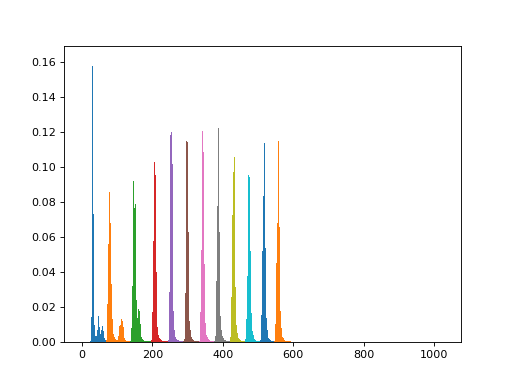

In [292]:
plt.figure()
data_w_max = []
for i in data:
    a =  plt.hist(i['efine'],bins=1024,density=1,range=[0,1024])
    data_w_max.append(a[1][np.argmax(a[0])])

<IPython.core.display.Javascript object>


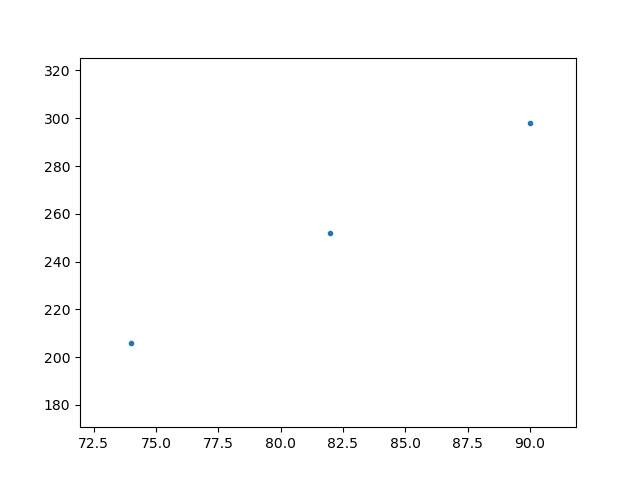

In [283]:
plt.figure()
plt.plot(windows,data_w_max,'.')

# Fake Data building

In [244]:
tac_id_v   = np.ones((len(windows),1))
channel_id = np.ones((len(windows),1))*5
sigma     = np.ones((len(windows),1))

data_array = np.concatenate([channel_id,tac_id_v,np.array(windows).reshape(-1,1),
                             np.array(data_w_max).reshape(-1,1),
                             sigma],axis=1)

data_df = pd.DataFrame(data_array,columns=['channel_id','tac_id','tpulse','mu','sigma'])                            

In [245]:
data_df

,channel_id,tac_id,tpulse,mu,sigma
0,5.0,1.0,50.0,31.0,1.0
1,5.0,1.0,58.0,76.0,1.0
2,5.0,1.0,66.0,146.0,1.0
3,5.0,1.0,74.0,206.0,1.0
4,5.0,1.0,82.0,252.0,1.0
5,5.0,1.0,90.0,298.0,1.0
6,5.0,1.0,98.0,342.0,1.0
7,5.0,1.0,106.0,386.0,1.0
8,5.0,1.0,114.0,431.0,1.0
9,5.0,1.0,122.0,476.0,1.0


<IPython.core.display.Javascript object>


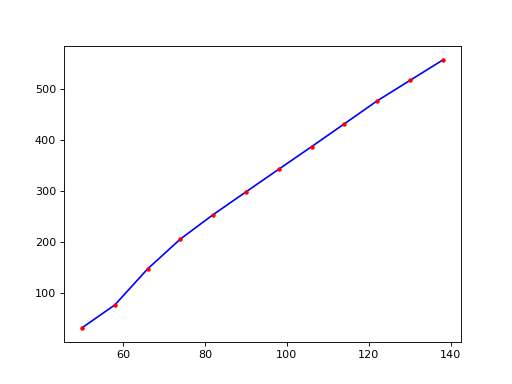

In [287]:
fig = plt.figure()
axis = fig.add_subplot(111)
poly_conf = TPcal.QDC_fit_p(data_df,5,1,plot=True,axis=axis)#,sigmas=np.ones(12),axis=axis)

In [249]:
poly_conf

array([ 1.86479009e-02, -4.35175376e-04,  3.42575520e+00, -2.82834266e-01,
        9.59006924e-03, -1.73626746e-04,  1.82876409e-06, -1.12724892e-08,
        3.78045704e-11, -5.33718995e-14])

In [195]:
tofpet_id  = np.array([0,0,0,0]).reshape(4,1)
channel_id = np.array([5,5,5,5]).reshape(4,1)
tac_id     = np.array([0,1,2,3]).reshape(4,1)
poly_v     = poly_conf.reshape(-1,10)
poly_v     = np.concatenate((poly_v,poly_v,poly_v,poly_v))

coeff_array = np.concatenate((tofpet_id,channel_id,tac_id,poly_v),axis=1)
print(coeff_array.shape)

coef_df = pd.DataFrame(coeff_array,columns=['tofpet_id', 'channel_id', 'tac_id','c0', 
                                            'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
coef_df

(4, 13)


,tofpet_id,channel_id,tac_id,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,0.0,5.0,0.0,0.022388,-0.00935,4.110761,-0.340239,0.011571,-0.000211,0.000002,-1.386374e-08,4.687677e-11,-6.675215e-14
1,0.0,5.0,1.0,0.022388,-0.00935,4.110761,-0.340239,0.011571,-0.000211,0.000002,-1.386374e-08,4.687677e-11,-6.675215e-14
2,0.0,5.0,2.0,0.022388,-0.00935,4.110761,-0.340239,0.011571,-0.000211,0.000002,-1.386374e-08,4.687677e-11,-6.675215e-14
3,0.0,5.0,3.0,0.022388,-0.00935,4.110761,-0.340239,0.011571,-0.000211,0.000002,-1.386374e-08,4.687677e-11,-6.675215e-14


In [289]:
data_test   = pd.read_hdf('/analysis/10923/hdf5/data/run_10923_0000_trigger1_waveforms.h5',key='data',start=0,stop=100000)

bd.compute_integration_window_size(data_test)

data_test['efine'] = (data_test['efine'] - 1024 + 14) % 1024

data_corrected = bd.apply_qdc_poly_correction(data_test[(data_test['tofpet_id']==0) & 
                                              (data_test['channel_id']==5)],coef_df)

<IPython.core.display.Javascript object>


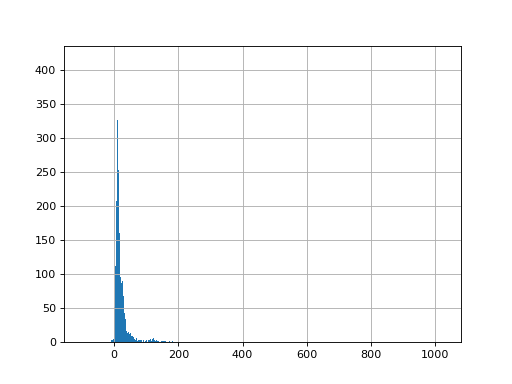

<AxesSubplot:>

In [290]:
plt.figure()
data_corrected[data_corrected['intg_w']>72]['efine_corrected'].hist(bins=1024,range=(-100,1024))

<IPython.core.display.Javascript object>


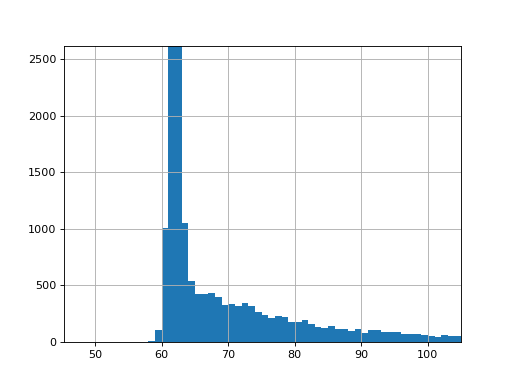

<AxesSubplot:>

In [291]:
plt.figure()
data_corrected['intg_w'].hist(bins=1024,range=(0,1024))

,channel_id,tac_id,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,tofpet_id
0,0,0,-50315.466641,6057.699576,-289.214361,7.383589,-0.112880,0.001084,-0.000007,2.472201e-08,-5.197548e-11,4.694230e-14,0
1,0,1,-50379.161894,6065.022739,-289.555301,7.392031,-0.113003,0.001085,-0.000007,2.474264e-08,-5.201339e-11,4.697150e-14,0
2,0,2,-50667.372775,6099.847045,-291.261816,7.436715,-0.113701,0.001092,-0.000007,2.490229e-08,-5.235256e-11,4.728060e-14,0
3,0,3,-50775.841227,6111.391064,-291.755585,7.447982,-0.113855,0.001094,-0.000007,2.492673e-08,-5.239937e-11,4.731962e-14,0
4,1,0,-51742.069431,5750.605419,-253.967668,6.033216,-0.086422,0.000783,-0.000005,1.618261e-08,-3.264559e-11,2.841723e-14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,62,3,-50758.750983,6113.549477,-291.985948,7.454664,-0.113938,0.001094,-0.000007,2.491731e-08,-5.236028e-11,4.726944e-14,0
248,63,0,-49780.861335,6003.649220,-287.002136,7.334330,-0.112211,0.001078,-0.000007,2.461007e-08,-5.175330e-11,4.674956e-14,0
249,63,1,-49718.319029,5996.047724,-286.618031,7.323705,-0.112033,0.001077,-0.000007,2.455911e-08,-5.163744e-11,4.663722e-14,0
250,63,2,-49800.825402,6003.991116,-286.912386,7.329167,-0.112088,0.001077,-0.000007,2.455702e-08,-5.162625e-11,4.662219e-14,0


In [282]:
with pd.HDFStore("/home/vherrero/CALIBRATION_FILES/asic0_efine_cal_poly_run10925.h5",'w',complib="zlib",complevel=4) as storage:
    storage.put('efine',overwrite,index=False,format='table',data_columns=None)
    storage.close()